# Introduction

As part of your final assignment in this course, this notebook will cover the full end to end data science pipeline, from the initial visualizations to the final predictions.  

In [1]:
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np


## Installation

You will need to install Keras and a deep learning backend. At this point, installation of these libraries should be relatively painless however you should try to install early on. You can use either Theano or Tensorflow, however since Theano is officially supported on all major operating systems that will be the one we can give the most support for. 

Note for Windows users: You'll need to install extra dependencies. By far the easiest way to do this (since you're running on Anaconda) is to run the following:
    
    conda install mingw libpython

Otherwise, you should be able to install necessary libraries with PyPI. 

    pip install Theano
    pip install keras

If you run into trouble, you can check out their documentation located at http://deeplearning.net/software/theano/install.html# and https://keras.io/#installation.

## Image Dataset

Before we get to using the neural networks, as you are probably used to by now, we must fetch and process the data. For this assignment, you will be using the Oxford-IIIT pet dataset. Go download it from here: 

    http://www.robots.ox.ac.uk/~vgg/data/pets/
    
It is a non-trivial download of ~800MB containing a collection of cats and dogs, annotated with their breed, head ROI (region of interest), and a pixel level segmentation. First we will need to canonicalize the images. We will do so using the `pillow` package, which should be already included in your Anaconda installations. If you'd like to know more, you can view the tutorial here: https://pillow.readthedocs.io/en/3.4.x/handbook/tutorial.html

JPEG (600, 400) RGB


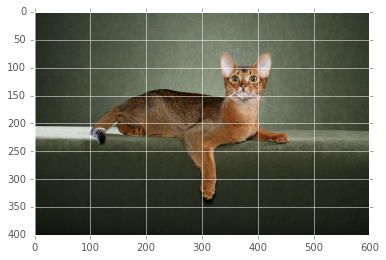

In [2]:
from PIL import Image

def plot_image(im):
    plt.imshow(np.asarray(im))

# AUTOLAB_IGNORE_START
im_cat = Image.open("images/Abyssinian_1.jpg")
print im_cat.format, im_cat.size, im_cat.mode
plot_image(im_cat)

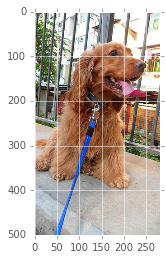

In [3]:
im_dog = Image.open("images/english_cocker_spaniel_198.jpg")
plot_image(im_dog)
# AUTOLAB_IGNORE_STOP

## Canonicalizing Images [5pts]
Suppose we tried to use the raw pixel data, similar to the previous homework with the Bush and Powell faces. You'll immediately realize a problem: all the images are of different shapes and sizes (e.g. the above two pictures)! This means we cannot throw them straight away into an SVM, for example. Without using fairly advanced techniques, we will have to do some processing or feature extraction to get a consistent number of features per example. 

Here we will take a simple approach: I've done some inspection for you and noticed that every picture has at least 100 pixels in either width or height. Thus, we will crop each image down to be a square picture, then scale it down to 100x100 pixels. 

### Specification
1. First, crop the image to be a square by reducing one dimension to be the same size as the other. You should center your cropping as much as possible (e.g. crop the same number of pixels from the left as from the right). If you must crop an odd number of pixels, then crop an extra pixel from the right or from the bottom. 
2. Second, resize the image to be 100 by 100 pixels. You should use the `Image.ANTIALIAS` filter for the resample parameter. 

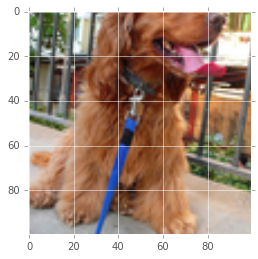

In [4]:
def crop_and_scale_image(im):
    """ Crops and scales a given image. 
        Args: 
            im (PIL Image) : image object to be cropped and scaled
        Returns: 
            (PIL Image) : cropped and scaled image object
    """
    cropped = np.array(im)
    if cropped.shape[1]>cropped.shape[0]:
        diff = cropped.shape[1] - cropped.shape[0]
        if diff %2 == 0:
            cropped = cropped[:,diff/2:cropped.shape[1]-diff/2]
        else:
            cropped = cropped[:,diff/2:cropped.shape[1]-diff/2-1]
    
    elif cropped.shape[0]>cropped.shape[1]:
        diff = cropped.shape[0] - cropped.shape[1]
        if diff %2 == 0:
            cropped = cropped[diff/2:cropped.shape[0]-diff/2,:]
        else:
            cropped = cropped[diff/2:cropped.shape[0]-diff/2-1,:] 
    
    size = (100,100)
    img = Image.fromarray(cropped)
    img.thumbnail(size,Image.ANTIALIAS)
    return img
        

# AUTOLAB_IGNORE_START  
plot_image(crop_and_scale_image(im_cat))
plot_image(crop_and_scale_image(im_dog))
# AUTOLAB_IGNORE_STOP

## Train / Validate / Test splits for large datasets
Next we will load the data and perform our usual data split. However, the image dataset is **very large**. So large, that if you try to load every image and process them at in batch, your computer may run out of memory (mine did). Thus, initially we will work with the filenames until it is a manageable size. This code assumes that your downloaded images exist in a folder `images/`, and creates an array of filepaths to each image. 

In [5]:
# AUTOLAB_IGNORE_START  
import os
dname = "images/"
im_paths = np.array([dname+fname for fname in os.listdir(dname) if fname.endswith(".jpg")])
P = np.random.permutation(len(im_paths))

split = 2000
fnames_tr, fnames_va, fnames_te = im_paths[P[:split]], im_paths[P[split:2*split]], im_paths[P[2*split:]]

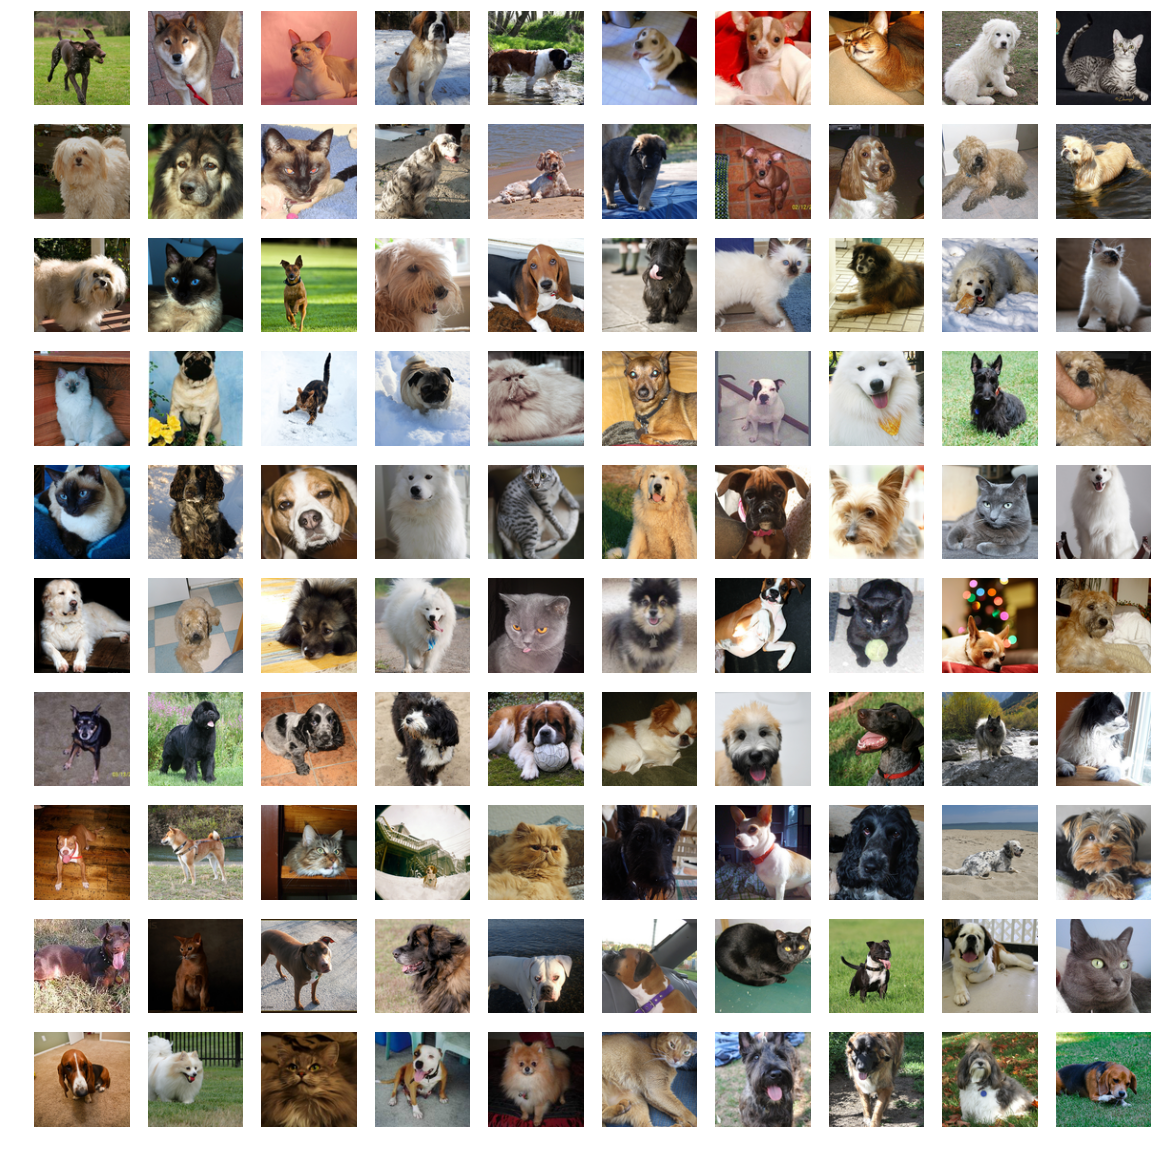

In [6]:
plt.figure(figsize=(20,20))
for i,fname in enumerate(fnames_tr[:100]):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plot_image(crop_and_scale_image(Image.open(fname)))
# AUTOLAB_IGNORE_STOP

## Filename Parsing [2+3pts]

We will need to extract the breeds and inputs for our VGG network from these files. Implement the following two helper functions to do this. 

### Specification
* Extract the full breed name from each filename, which is the part of the filename not including the number and the extension. See the example output for an example. 
* Using your `crop_and_scale_image` function from earlier, generate the image data matrix that is to be input into VGG. 
* Note that VGG requires its input dimension to be in a slightly different order than that returned by Pillow. Use `np.rollaxis` to rotate it until in the proper order. 
* Some of the images are not in RGB format. You will have to convert them to RGB. 

In [7]:
import re
def fname_to_breed(fname):
    """ Extracts the breed from a filename
        Args: 
            fname (string) : the filename to be parsed
        Returns: 
            (string) : the breed extracted from the filename
    """
    z = fname.split(".")
    z = z[0][7:]
    for j,i in enumerate(z):
        if i=="_":
            idx = j
    return z[:idx]
    
def fname_to_vgg_input(fname):
    """ Creates the input for a VGG network from the filename 
        Args: 
            fname (string) : the filename to be parsed
        Returns: 
            (numpy ndarray) : the array to be passed into the VGG network as a single example
    """
    im_breed = Image.open(fname)
    cropped_img = crop_and_scale_image(im_breed)
    arr_img = np.asarray(cropped_img)
    return np.rollaxis(arr_img,2)

# AUTOLAB_IGNORE_START
print fname_to_breed("images/english_cocker_spaniel_144.jpg")
print fname_to_vgg_input("images/Abyssinian_1.jpg")
# AUTOLAB_IGNORE_STOP

english_cocker_spaniel
[[[59 61 61 ..., 74 72 71]
  [58 59 61 ..., 76 72 70]
  [59 62 65 ..., 75 71 70]
  ..., 
  [21 21 22 ..., 23 25 26]
  [18 19 19 ..., 23 24 23]
  [16 17 18 ..., 22 21 22]]

 [[70 72 72 ..., 87 85 82]
  [69 69 72 ..., 89 84 81]
  [69 71 74 ..., 86 83 82]
  ..., 
  [27 26 28 ..., 29 31 32]
  [25 27 27 ..., 29 30 29]
  [23 25 26 ..., 28 27 28]]

 [[53 55 55 ..., 69 67 65]
  [52 52 55 ..., 71 66 64]
  [53 54 57 ..., 69 65 62]
  ..., 
  [17 19 20 ..., 19 21 22]
  [17 16 17 ..., 19 20 19]
  [15 14 15 ..., 18 17 18]]]


Our implementation gets the following output: 
     
    english_cocker_spaniel
    [[[59 61 61 ..., 74 72 71]
      [58 59 61 ..., 76 72 70]
      [59 62 65 ..., 75 71 70]
      ..., 
      [21 21 22 ..., 23 25 26]
      [18 19 19 ..., 23 24 23]
      [16 17 18 ..., 22 21 22]]

     [[70 72 72 ..., 87 85 82]
      [69 69 72 ..., 89 84 81]
      [69 71 74 ..., 86 83 82]
      ..., 
      [27 26 28 ..., 29 31 32]
      [25 27 27 ..., 29 30 29]
      [23 25 26 ..., 28 27 28]]

     [[53 55 55 ..., 69 67 65]
      [52 52 55 ..., 71 66 64]
      [53 54 57 ..., 69 65 62]
      ..., 
      [17 19 20 ..., 19 21 22]
      [17 16 17 ..., 19 20 19]
      [15 14 15 ..., 18 17 18]]]


## VGG [10pts]

As mentioned in lecture, one of the common ways to use deep learning is to automatically learn features. For this problem, we will use a pretrained VGG network to create useful features. Tuning and training your own custom neural networks takes a significant amount of time and effort (much more so than running SVM with RBF features, as you may have noticed from the last homework) so we will use the pretrained network VGG-16 from https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3. You will need to download the weights file `vgg16_weights.h5`. You will also find their sample  script `vgg-16_keras.py` to be very helpful. 

If you want to run their full script, you'll also need opencv, though it is not necessary and you can just delete the references to it from the script.  

    conda install -c menpo opencv

### Specification
* Load the VGG model from the weights, and construct a new network with the same weights but without the last two dense and dropout layers. 

In [8]:
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16(weights_path=None):
    """ Loads a pretrained VGG network without its dense layers. 
        Args: 
            weights_path (string) : the path to the weights file containing the pretrained weights
        Returns: 
            (keras model) : the VGG-16 model without its dense layers
    """
    img_width, img_height = 224, 224

    # build the VGG16 network
    first_layer = ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height))

    model = Sequential()
    model.add(first_layer)
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path)
        
    model.pop()
    model.pop()
    model.pop()
    new_weights = model.get_weights()
    first_layer = ZeroPadding2D((1, 1), input_shape=(3, 100, 100))

    model = Sequential()
    model.add(first_layer)
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.set_weights(new_weights)
    return model

# # # load the weights
#     import h5py
# #     # get the symbolic outputs of each "key" layer (we gave them unique names).
#     layer_dict = dict([(layer.name, layer) for layer in model.layers])
#     f = h5py.File("vgg16_weights.h5")
#     for k in range(f.attrs['nb_params']):
#         if k >= len(model.layers):
#             # we don't look at the last (fully-connected) layers in the savefile
#             break
#         g = f['layer_{}'.format(k)]
#         weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
#         model.layers[k].set_weights(weights)
#     f.close()
#     return model

    
# AUTOLAB_IGNORE_START
truncated_vgg = VGG_16("vgg16_weights.h5")
# AUTOLAB_IGNORE_STOP

Using Theano backend.


## Converting files to features and labels [2+3pts]
Now we have all the parts to convert our image files to features and labels. Implement the following two functions that turn filenames into labels and filenames to features. 

### Specification
* You should take all the breeds and sort them in alphabetical order. Then, assign the a label of 0 to the first, and so on, so that the last breed in alphabetical order has a label of 36. 
* The features are the flattened output of the last pooling layer of the VGG network.

In [9]:
def fnames_to_labels(fnames):
    """ Given a list of filenames, generate the corresponding array of labels
        Args: 
            fnames (list) : A list of filenames
        Returns: 
            (numpy ndarray) : a 1D array of numerical labels
    """
    proc_list = []
    for i in fnames:
        proc_list.append(fname_to_breed(i))

    z = sorted(proc_list,key = str.lower)
    dict_animals = dict(enumerate(sorted(np.unique(z),key = str.lower)))
    inv_animals = {v: k for k, v in dict_animals.iteritems()}
    
    label_list = []
    for i in proc_list:
        label_list.append(inv_animals[i])
        
    
    return np.asarray(label_list)
    

# AUTOLAB_IGNORE_START
fnames_to_labels(fnames_tr[:10])
# AUTOLAB_IGNORE_STOP

array([4, 7, 8, 6, 6, 1, 2, 0, 5, 3])

In [10]:
def fnames_to_features(fnames, vgg):
    """ Given a list of filenames and a VGG16 model, generate the corresponding array of VGG features
        Args: 
            fnames (list) : A list of filenames
            vgg (keras model) : a pretrained VGG16 model
        Returns: 
            (numpy ndarray) : a 2D array of features generated from the VGG model
    """
    output = []
    for i in fnames:
        im = fname_to_vgg_input(i)
        im = np.expand_dims(im, axis=0)
        output.append(vgg.predict(im))
    return output
# AUTOLAB_IGNORE_START
fnames_to_features(fnames_tr[:10], truncated_vgg)
# AUTOLAB_IGNORE_STOP

[array([[  2.47073555e+00,   5.96046448e-07,   5.96046448e-07, ...,
           1.50501728e-06,   1.50501728e-06,   1.50501728e-06]], dtype=float32),
 array([[  5.96046448e-07,   5.96046448e-07,   1.99244249e+00, ...,
           1.50501728e-06,   1.50501728e-06,  -4.02331352e-07]], dtype=float32),
 array([[  5.96046448e-07,   5.96046448e-07,   5.96046448e-07, ...,
           1.50501728e-06,   1.50501728e-06,   1.50501728e-06]], dtype=float32),
 array([[  5.96046448e-07,   1.88961678e+01,   1.42053175e+01, ...,
          -4.02331352e-07,   1.50501728e-06,   1.50501728e-06]], dtype=float32),
 array([[  4.81393242e+01,   1.52026033e+01,   5.96046448e-07, ...,
          -4.02331352e-07,  -4.02331352e-07,   2.99492855e+01]], dtype=float32),
 array([[  5.96046448e-07,   5.96046448e-07,   5.96046448e-07, ...,
           1.50501728e-06,   1.50501728e-06,   1.50501728e-06]], dtype=float32),
 array([[  5.96046448e-07,   5.96046448e-07,   5.96046448e-07, ...,
           7.45058060e-08,   1.5050172

## And now we wait... just kidding. 
Now, you can run this on the entirety of the training, validation, and test set... but wait. Our machines take about 2 seconds per example to generate VGG examples without any GPU acceleration, which means that processing all the images will be a several hour endeavor (about 8 hours on our machines)! To save you some time, we've already run this on a random training and validation set (2k examples each), in `X_tr.txt` and `y_va.txt`. You can find their labels in `y_tr.txt` and `y_va.txt`. 

In [11]:
# AUTOLAB_IGNORE_START
X_tr = np.loadtxt("X_tr.txt")
X_va = np.loadtxt("X_va.txt")
# AUTOLAB_IGNORE_STOP

In [12]:
# AUTOLAB_IGNORE_START
y_tr = np.loadtxt("y_tr.txt", dtype=int)
y_va = np.loadtxt("y_va.txt", dtype=int)
# AUTOLAB_IGNORE_STOP

## Pet breed classification from VGG features [8pts]

And now for the final task: you will now classify the pets by breed using the generated VGG features. Your goal here is to get at least 50% classification accuracy on the pets dataset. You will be given the 4k random examples above to build your model (the train and validation datasets), and we will evaluate your model on a holdout test set. 

### Baseline approach

The baseline approach here is to use yet another neural network. A simple network that isn't too large can train to about 55% accuracy in a minute on our machines. Try different configurations with different learners and architectures. You must get at least 50% accuracy to receive credit for this problem. You can use the training/validation split that we gave you to estimate the performance of your model on autolab prior to submission. 

### Contest rules

We've increased the time alotted for autograding to 6 minutes per submission. Other than that, there are no restrictions on your models for this contest (yes, you can use sklearn). You may use any library on Autolab. Use everything you've learned in this course to create the best pet classifier you can! 

If you find that you really need to use something that isn't on Autolab, let us know early on and we can try to put it in.

### Specification
* We will give your model 4k training examples, and evaluate its accuracy on a holdout set. 
* Scores of 50% or more will receive full homework credit

In [42]:
import time
from sklearn.svm import LinearSVC
def predict_from_features(X, Y, X_te):
    """ Given labelsf and VGG features, predict the breed of the testing set. 
    Args: 
        X (numpy ndarray) : 2D array of VGG features, each row is a set of features for a single example
        y (numpy ndarray) : 1D array of labels corresponding to the features in X
        X_te (numpy ndarray) : 2D array of VGG features for unlabeled examples
    Returns: 
        (numpy ndarray) 1D array of predicted labels for the unlabeled examples in X_te
    """
    clf = LinearSVC()
    clf.fit(X,Y)
    
    return clf.predict(X_te)
    
# AUTOLAB_IGNORE_START
start = time.time()
y_p = predict_from_features(X_tr, y_tr, X_va)
end = time.time()
print "Validation accuracy: {} in {} seconds".format(np.mean(y_p==y_va), end-start)

# AUTOLAB_IGNORE_STOP

Validation accuracy: 0.571 in 366.220000029 seconds
